Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Resource Conservation and Recovery Act Inspections by Congressional District

This notebook examines ECHO data using ECHO_EXPORTER, RCRA_FACILITIES,
and RCRA_EVALUATIONS.

From ECHO_EXPORTER:
<ul>
    <li>RCRA_IDS - to match facilities/violations in RCRA_FACILITIES and RCRA_EVALUATIONS</li>
    <li>FAC_DERIVED_CD113 - 113th congressional district</li>
    <li>FAC_LAT and FAC_LONG - latitude and longitude</li>
    <li>RCRA_PERMIT_TYPES</li>
</ul>

RCRA Permit Types include:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>

From RCRA_EVALUATIONS we get:
<ul>
    <li>EVALUATION_DESC - a description of the evaluation</li>
    <li>EVALUATION_AGENCY - the agency that conducted the evaluation</li>
    <li>EVALUATION_START_DATE</li>
</ul>

A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


Run this next cell, select a state, and then run the following cell.

In [4]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [5]:
my_state = dropdown_state.value

sql = "select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, RCRA_IDS, " + \
    "RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'" + \
    "and FAC_STATE = '" + my_state + "'" 
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)


select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, RCRA_IDS, RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'and FAC_STATE = 'NY'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20RCRA_IDS%2C%20RCRA_PERMIT_TYPES%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20RCRA_FLAG%20%3D%20%27Y%27and%20FAC_STATE%20%3D%20%27NY%27


In [8]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
num_facilities = echo_data.shape[0]

print("There are %s RCRA facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 115135 RCRA facilities in NY tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.
Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [10]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…



Run this next cell after choosing a congressional district from the dropdown list.

In [11]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s RCRA facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 2797 RCRA facilities in NY district 1 tracked in the ECHO database.


Next look up the inspection history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [13]:
sql = "select ID_NUMBER, EVALUATION_DESC, EVALUATION_AGENCY, EVALUATION_START_DATE " + \
        " from `RCRA_EVALUATIONS` where ID_NUMBER like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
# print(data_location)
rcra_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
rcra_data.set_index( "ID_NUMBER", inplace=True)
rcra_data

,EVALUATION_DESC,EVALUATION_AGENCY,EVALUATION_START_DATE
ID_NUMBER,,,
NYN008023566,COMPLIANCE EVALUATION INSPECTION ON-SITE,E,02/05/2011
NYN008023582,COMPLIANCE EVALUATION INSPECTION ON-SITE,E,02/12/2011
NY0000374363,COMPLIANCE SCHEDULE EVALUATION,E,02/14/1997
NY0000374363,COMPLIANCE EVALUATION INSPECTION ON-SITE,E,02/14/1997
NY0000374389,NON-FINANCIAL RECORD REVIEW,E,06/02/1994
...,...,...,...
NYD986921237,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,03/05/2020
NYD084006741,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,03/05/2020
NYD022071336,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,10/04/2018


In [14]:
# The RCRA_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in RCRA_VIOLATION_HISTORY.

cd_rcra = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # print( type( fac ))
    # breakpoint()
    ids = fac.RCRA_IDS
    # Look at each RCRA_ID belonging to the facility
    for rcra_id in ids.split():
        try:
            # Find the rcra_id in the RCRA_VIOLATION_HISTORY, if any exist there.
            # It can match a ID_NUMBER, which is the index of rcra_data.
            rcra_fac = rcra_data.loc[ rcra_id ].copy()
            # Add the facility's index number to rcra_fac, to refer to it.
            n = rcra_fac.shape[0]
            fac_list = [fac.Index] * n
            rcra_fac['facility'] = fac_list
            # Make a frame that contains the violations.  Add it to my_cd_icis.
            frames = [cd_rcra, rcra_fac]
            cd_rcra = pd.concat( frames, ignore_index=False )
        except KeyError:
            # The air_id wasn't found in RCRA_VIOLATION_HISTORY.
            no_data_ids.append( rcra_id )

cd_rcra

# my_cd_icis.to_csv( r'my_cd_icis.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))

,0,EVALUATION_AGENCY,EVALUATION_DESC,EVALUATION_START_DATE,facility
EVALUATION_DESC,COMPLIANCE EVALUATION INSPECTION ON-SITE,NaN,NaN,NaN,NaN
EVALUATION_AGENCY,S,NaN,NaN,NaN,NaN
EVALUATION_START_DATE,10/01/1999,NaN,NaN,NaN,NaN
facility,"[64, 64, 64]",NaN,NaN,NaN,NaN
EVALUATION_DESC,COMPLIANCE EVALUATION INSPECTION ON-SITE,NaN,NaN,NaN,NaN
...,...,...,...,...,...
facility,"[114987, 114987, 114987]",NaN,NaN,NaN,NaN
NYD075782987,NaN,S,COMPLIANCE EVALUATION INSPECTION ON-SITE,03/12/1993,115035.0
NYD075782987,NaN,E,COMPLIANCE EVALUATION INSPECTION ON-SITE,09/26/1997,115035.0
NYD072379837,NaN,E,COMPLIANCE EVALUATION INSPECTION ON-SITE,06/23/1999,115047.0


Map the facilities that have had these serious CAA violations.

In [15]:
fac_idx_list = cd_rcra['facility'].dropna()
fac_cd_rcra = my_cd_facs.loc[fac_idx_list]
fac_cd_rcra

,FAC_NAME,FAC_STATE,FAC_LAT,FAC_LONG,RCRA_IDS,RCRA_PERMIT_TYPES,FAC_DERIVED_CD113
305.0,NORTHVILLE HOLTSVILLE TERMINAL,NY,40.812503,-73.065525,NY0000096123 NYD980646129 NYD986912483,"LQG, Other, VSQG",1.0
305.0,NORTHVILLE HOLTSVILLE TERMINAL,NY,40.812503,-73.065525,NY0000096123 NYD980646129 NYD986912483,"LQG, Other, VSQG",1.0
357.0,THOMPSON AIRCRAFT TIRES,NY,40.809490,-73.234550,NYD174569657,Other,1.0
357.0,THOMPSON AIRCRAFT TIRES,NY,40.809490,-73.234550,NYD174569657,Other,1.0
457.0,VOJVODA CLEANERS,NY,40.921360,-72.653650,NYD101204246,VSQG,1.0
...,...,...,...,...,...,...,...
114904.0,STONY BROOK UNIVERSITY,NY,40.920898,-73.133462,NYD040464315 NYR000104570,"LQG, Other",1.0
115035.0,SEARLES GRAPHICS INC,NY,40.771820,-72.956540,NYD075782987,Other,1.0
115035.0,SEARLES GRAPHICS INC,NY,40.771820,-72.956540,NYD075782987,Other,1.0
115047.0,POLYMER PLASTICS CORP,NY,40.818810,-73.260060,NYD072379837,Other,1.0


In [16]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_cd = mapper(fac_cd_rcra)
map_of_facilities_in_cd

Present another dropdown with the list of names of the facilities.  Choosing a facility will display the evaluations.

In [17]:
cd_array = fac_cd_rcra["FAC_NAME"].unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('106TH RESCUE WING, NEW YORK AIR NATIONAL GUARD', '895 WAVERLY…

Run this next cell after choosing a facility.

RCRA Permit Types:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>

In [18]:
my_fac = fac_cd_rcra[fac_cd_rcra["FAC_NAME"] == w3.value]
evaluations = cd_rcra[cd_rcra['facility'] == my_fac.iloc[[0]].index[0]]
print( my_fac.iloc[0] )
evaluations


FAC_NAME             AMNEAL PHARMACEUTICALS BROOKHAVEN FACILITY
FAC_STATE                                                    NY
FAC_LAT                                                 40.8575
FAC_LONG                                               -73.0758
RCRA_IDS                                           NYR000131920
RCRA_PERMIT_TYPES                                           LQG
FAC_DERIVED_CD113                                             1
Name: 7711.0, dtype: object


,0,EVALUATION_AGENCY,EVALUATION_DESC,EVALUATION_START_DATE,facility
NYR000131920,NaN,S,COMPLIANCE EVALUATION INSPECTION ON-SITE,05/05/2008,7711.0
NYR000131920,NaN,S,COMPLIANCE EVALUATION INSPECTION ON-SITE,10/10/2013,7711.0
NYR000131920,NaN,S,FOCUSED COMPLIANCE INSPECTION,07/16/2014,7711.0
NYR000131920,NaN,S,COMPLIANCE EVALUATION INSPECTION ON-SITE,05/08/2017,7711.0
NYR000131920,NaN,S,COMPLIANCE EVALUATION INSPECTION ON-SITE,08/14/2018,7711.0


In [19]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format, chart_title ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            # breakpoint()
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title +=  " in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

## Plot the number of evaluations by year for the congressional district.

                 YEAR_EVALUATION
YEAR_EVALUATION                 
1983.0                         4
1984.0                        14
1985.0                        25
1986.0                        25
1987.0                        24
1988.0                        23
1989.0                        21
1990.0                        16
1991.0                        16
1992.0                        15
1993.0                        15
1994.0                        16
1995.0                        37
1996.0                        17
1997.0                        32
1998.0                        40
1999.0                        46
2000.0                        21
2001.0                        25
2002.0                        18
2003.0                        20
2004.0                        21
2005.0                        23
2006.0                        21
2007.0                        29
2008.0                        32
2009.0                        27
2010.0                        29
2011.0    

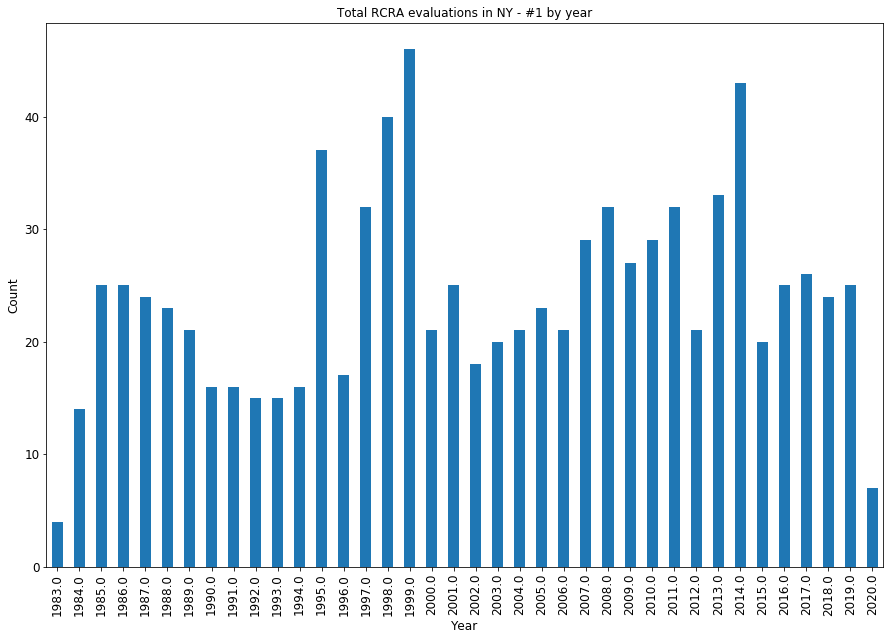

In [20]:
chart_title = "Total RCRA evaluations"

show_plot( cd_rcra, 'EVALUATION_START_DATE', 'YEAR_EVALUATION', \
          my_state + ' - #' + str( my_cd ), '%m/%d/%Y', chart_title )

## Plot the number of evaluations by year, using the entire state.
Since the number of evaluations in a single CD may be small, it can be more
interesting to look at the entire state.

                 YEAR_EVALUATION
YEAR_EVALUATION                 
1980                           1
1981                           7
1982                          20
1983                         256
1984                         952
1985                        1119
1986                        1491
1987                        1579
1988                        1331
1989                        1071
1990                        1145
1991                        1004
1992                        1087
1993                        1551
1994                         948
1995                        1266
1996                        1124
1997                        1139
1998                        1375
1999                        1316
2000                        1048
2001                        1053
2002                        1174
2003                        1018
2004                        1000
2005                         935
2006                        1020
2007                        1108
2008      

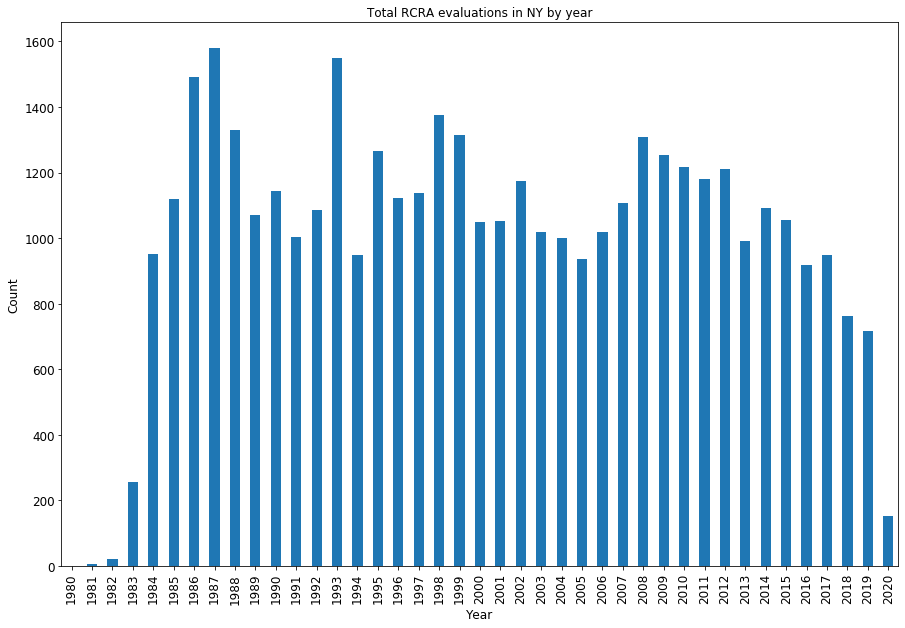

In [21]:
show_plot( rcra_data, 'EVALUATION_START_DATE', 'YEAR_EVALUATION', \
          my_state, '%m/%d/%Y', chart_title )